## In this Ipnyb , I'm going to build a model that can classify the Clothing Attribute Dataset which can be found at https://purl.stanford.edu/tb980qz1002 by the Category label. This is an image recognition and classification task . This dataset has only 1800 samples , out of which around 1100 samples have non - Nan values .

##  ->Therefore , the approach to be followed will be :
## Use Transfer learning ( in this case VGGNet16 trained on Imagenet data ) to learn weights for our features

## -> Train our features against a classifier . Our choice of classifier here is SVM

In [1]:
import keras
import scipy.io as sio
import os
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import h5py
from keras.utils.np_utils import to_categorical
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
from keras.optimizers import Adam
# Plot images
from keras.datasets import mnist
from matplotlib import pyplot
import pickle
#import cv2

Using TensorFlow backend.


In [2]:
image_dir = "/images"
label_file = "/labels/category_GT.mat"

## The first step is to load our data and labels . The data is stored in the images folder as folders. The label is stored in a matlab file . The name of the file , corresponds to its label index (plus 1 as image names start from 1) .
## To fix this , we first read all image file names in a list , sort the list and then parse files in ascending order, matching with the order of their labels¶

In [16]:
#get labels from the category label file for the task 

mat_contents = sio.loadmat(os.getcwd() + label_file)['GT']
train_labels=np.array(mat_contents)

print "training labels loaded"
#print train_labels.shape

file_list = [f for f in os.listdir(os.getcwd() + image_dir) if os.path.isfile(os.path.join(os.getcwd() + image_dir, f))]
file_list.sort()

#get train data
inputShape = (150, 150)
img_list =[]
# for filename in os.listdir(os.getcwd() + image_dir):
for filename in file_list:
    qualified_filename = os.getcwd() + image_dir + "/" + filename
    #print filename
    
    #print("[INFO] loading and pre-processing image...")
    image = load_img(qualified_filename, target_size=inputShape)
    #print (image.size)
    image = img_to_array(image)

    # our input image is now represented as a NumPy array of shape
    # (inputShape[0], inputShape[1], 3) 
    pos = filename.split(".")[0]
    pos = int(pos)
    #print pos
    
    
    #inserting the image at correct index that matches its label
    img_list.insert(pos -1 , image)
    print pos -1        

print "training data loaded"
train_data = np.array(img_list)  

print "shape of training data is " + str(train_data.shape)

#print img_list[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### We'll do some EDA now. Because this data is labeled for multiple categories, we will explicitly look for Nan labels and filter them out . This reduces the number of available samples to 1104

In [17]:
#removing nan values 
def get_filtered_data(train_data, train_labels):
    
    print "in Filter Data method"
    bool_label_array = np.isfinite(np.ravel(train_labels))
#     print bool_label_array
    train_data_filter = train_data[bool_label_array]
    print train_data_filter.shape
    
    train_labels_filter = train_labels[np.isfinite(train_labels)]
    print train_labels_filter.shape
    return (train_data_filter, train_labels_filter)

In [18]:
(train_data_filter, train_labels_filter) = get_filtered_data(train_data, train_labels)
print train_data.shape

in Filter Data method
(1104, 150, 150, 3)
(1104,)
(1856, 150, 150, 3)


#### It is important to see how the labels are distributed. If the data is biased towards one class, we might have to resample

In [19]:
# now let's see the distribution of classes 
from collections import Counter
print Counter(train_labels_filter)


Counter({7.0: 260, 5.0: 232, 4.0: 220, 1.0: 134, 3.0: 108, 2.0: 88, 6.0: 62})


### The data seems to be distributed fairly , therefore we don't need to do class balancing . Now we'll write a function that shuffles our data , whilst maintaining the relative indexes of data and labels

In [79]:
def shuffle_data(x_train, y_train_zero):
    idx = np.random.randint(len(y_train_zero), size=int(len(y_train_zero)))
    y_train_zero = y_train_zero[idx]
    x_train = x_train[idx, :]
    return x_train, y_train_zero
    

### Before we start training our model , it is important to split our data into training and testing (eval) data . This enforces that the model never sees the test data before we start evaluation and helps us measure the effectiveness of our models .
### Since the size of out dataset is 1104, we're splitting it roughly into 75 - 25 ratio of train and test data . After splitting the data , we also write these to numpy files which can be loaded into memory using auxillary methods provided at the end of the notebook
###  we shall use VGG16 to learn weights from the 16th layer of VGGNet for our images. Finally we'll save these features to a file

In [20]:
#load images 
# dimensions of our images.
top_model_weights_path = 'bottleneck_fc_model.h5'

epochs = 5
batch_size = 16

train_data_filter = train_data_filter/255

def save_bottleneck_features_without_augmentation():
    train_data_aug=[]
    train_labels_aug=[]

    
    model = applications.VGG16(include_top=False, weights='imagenet')
    print "loading gen on training data"

    
    print "generating augmentations of data"
    bottleneck_features_train =model.predict(
        train_data_filter,  verbose =1)

    
    return bottleneck_features_train, train_labels_filter

    
print "saving bottleneck features"
train_data_aug, train_labels_aug = save_bottleneck_features_without_augmentation()


saving bottleneck features
loading gen on training data
generating augmentations of data
1104/1104 [==============================] - 565s 512ms/step


In [28]:
#Compute one level accuaracy
def accuracy(matrix):
    return (np.trace(matrix)) * 1.0 / np.sum(matrix)

In [22]:

print train_data_aug.shape
print train_labels_aug.shape 

(1104, 4, 4, 512)
(1104,)


#### Visualizing our data : Let's see the first 9 images from the consolidated , as well as the evaluation and training datasets

/Users/shubhi/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


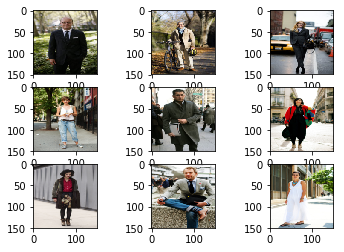

In [55]:
def plot_first_n_images(img_list=img_list,n=9):
    # load data  
    # create a grid of 3x3 images
    for i in range(0, n):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(img_list[i])
    # show the plot
    pyplot.show()
plot_first_n_images(train_data_filter)

### The features from VGGNet are very rich, but also very high in dimension ( 8192) . Since the size of our data is small, we shall be applying PCA to get the first 1000 more discriminative features. We chose the value 1000, after running hit and trial on a number of feature sizes to see which one produced the best evaluation metrics

In [49]:
#train_data_flat = np.reshape(train_data_aug,(8848, 67500) )
#print train_data_flat.shape
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pickle


# PCA
def pca(train_data_flat, num_features):
    import numpy as np
    from sklearn.decomposition import PCA

   
    pca = PCA(n_components=num_features)
    pca.fit(train_data_flat)


#     print(pca.explained_variance_ratio_)  
#     print(pca.singular_values_)  

    train_data_flat_pca = pca.transform(train_data_flat)
    print train_data_flat_pca.shape
    
    return train_data_flat_pca

train_data_flat = np.reshape(train_data_aug, (1104, 8192))
train_data_flat_pca = pca(train_data_flat, 1000)


(1104, 1000)


In [57]:
print train_data_aug.shape
print train_data_flat.shape
print train_data_flat_pca.shape
print train_labels_filter.shape

(1104, 4, 4, 512)
(1104, 8192)
(1104, 1104)
(1104,)


### We will now use the model with pre-trained weights and train them with a linear classifier . Since we've used augmentation with zero mean and PCA, we can't use Naive Bayes (doesn't take negative values) . The algorithms we'll test against are :
#### 1. Logistic Regression
#### 2. SVM ( Use grid search to find the best params and predict with the given parameters)
#### 3. Random Forest


In [51]:
#logistic regression
from sklearn import linear_model
from sklearn.metrics import f1_score
def lr(train_data, label, split):
    logistic_clf = linear_model.LogisticRegression(penalty="l2", class_weight="balanced", max_iter=100, verbose=1)
    logistic_clf.fit(train_data[:split], label[:split])
    pred = logistic_clf.predict(train_data[split:])
    print confusion_matrix(label[split:], pred)
    print accuracy(confusion_matrix(label[split:], pred))
    print f1_score(label[split:], pred, average= 'micro')
    print f1_score(label[split:], pred, average= 'macro')
    print f1_score(label[split:], pred, average= 'weighted')
                                 
# lr(train_data_flat, train_labels_aug, 850)


[LibLinear][[ 8  5  0  6  4  4 11]
 [ 4  1  0  0  1  2  7]
 [17 10 16  4  7 21 11]
 [ 1  0  0  2  2  0  1]
 [ 2  0  0  0  1  0  1]
 [ 2  1  0  1  1  3 10]
 [ 3  4  0  6  2  7 65]]
0.377952755906
0.377952755906
0.230884215517
0.385073626589


#### Running logistic Regression

In [91]:
train_data_flat_pca = pca(train_data_flat, 1000)
lr(train_data_flat_pca2, train_labels_aug2, 900)
train_data_flat_pca = pca(train_data_flat, 1104)
lr(train_data_flat_pca2, train_labels_aug2, 900)

(1104, 1000)
[LibLinear][[18  2  0  1  3  0  1]
 [ 0 11  1  1  0  1  1]
 [ 0  0 18  1  0  0  0]
 [ 1  2  0 36  4  1  1]
 [ 2  1  0  1 37  2  0]
 [ 0  2  0  2  0  8  0]
 [ 2  0  2  4  1  0 36]]
0.803921568627
0.803921568627
0.781799153228
0.804828015122
(1104, 1104)
[LibLinear][[18  2  0  1  3  0  1]
 [ 0 11  1  1  0  1  1]
 [ 0  0 18  1  0  0  0]
 [ 1  2  0 36  4  1  1]
 [ 2  1  0  1 37  2  0]
 [ 0  2  0  2  0  8  0]
 [ 2  0  2  4  1  0 36]]
0.803921568627
0.803921568627
0.781799153228
0.804828015122


#### running  SVM, first selecting the best parameters using Grid Search then using those params to evaluate results 


In [67]:
from sklearn.grid_search import GridSearchCV
def svm(train_data, train_labels_augmented):
    from sklearn import svm
    svc = svm.SVC(C=0.5, kernel='linear')
    param_grid = [
          {'C': [0.1, 0.5, 1, 5], 'kernel': ['linear']},
          {'C': [0.1, 0.5, 1, 5], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
         ]
    kernel = ['linear', 'rbf']
    Cs = [0.1, 0.3, 1]    
    clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, n_jobs=-1,)
    clf.fit(train_data, train_labels_augmented)
    print(clf.best_score_)
    print(clf.best_estimator_.C)
    print(clf.best_estimator_.kernel)
    print(clf.best_params_)
    return clf.cv_results_

In [68]:
# train_data_flat_pca = pca(train_data_flat, 1000)
cv_results_ = svm(train_data_flat_pca, train_labels_aug)
# train_data_flat_pca = pca(train_data_flat, 1104)
# lr(train_data_flat_pca, train_labels_aug, 850)

0.542572463768
5
rbf
{'kernel': 'rbf', 'C': 5, 'gamma': 0.001}


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [72]:
def svm_best(train_data, label, split):
    from sklearn import svm
    clf = svm.SVC(C=5, kernel='rbf', gamma = 0.001)
    clf.fit(train_data[:split], label[:split])
    pred = clf.predict(train_data[split:])
    print confusion_matrix(label[split:], pred)
    print accuracy(confusion_matrix(label[split:], pred))
    print f1_score(label[split:], pred, average= 'micro')
    print f1_score(label[split:], pred, average= 'macro')
    print f1_score(label[split:], pred, average= 'weighted')

In [86]:

train_data_flat_pca2, train_labels_aug2 = shuffle_data(train_data_flat_pca, train_labels_aug)
svm_best(train_data_flat_pca2, train_labels_aug2, 900)

[[18  2  0  0  3  0  2]
 [ 0 11  1  0  0  1  2]
 [ 0  0 18  1  0  0  0]
 [ 2  0  0 37  3  0  3]
 [ 3  0  0  0 39  0  1]
 [ 2  1  0  0  0  8  1]
 [ 1  0  0  3  0  0 41]]
0.843137254902
0.843137254902
0.82625183899
0.842381853777


#### Running Random Forest using Grid Search to get classifier with best performance. Since the outputs in grid search don't do better than LR and SVM , we don't go forward with evaluation

In [89]:
def random_forest(X, y, split):
    k_fold = 10
    kf_total = KFold(n_splits=k_fold)
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=250,
                                  random_state=0)
    #estimators_list = [50, 100, 150, 250, 500, 800, 1000]  
    estimators_list = [50, 150, 500]  
    clf_forest = GridSearchCV(estimator=forest, param_grid=dict(n_estimators=estimators_list, warm_start=[True, False]), cv=k_fold, n_jobs=-1)
    cms = [confusion_matrix(y[split:], clf_forest.fit(X[:split],y[:split]).predict(X[split:])) for train, test in kf_total.split(X)]
    accuracies = []
    for cm in cms:
        accuracies.append(accuracy(cm))
    print(accuracies)
    print(np.mean(accuracies))

random_forest(train_data_flat_pca2, train_labels_aug2, 900)

[0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135, 0.72549019607843135]
0.725490196078


# End of code in notebook 

Auxillary methods to load data from  pickle files

In [58]:
import pickle
file = open('train_data_1044.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(train_data_aug, file)
file.close()
file = open('train_label_v16_1044.pkl', 'wb')

# # Pickle dictionary using protocol 0.
pickle.dump(train_labels_filter, file)
file.close()

In [56]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [5]:
with open('train_data.pkl', 'rb') as f:
    train_data_augmented = pickle.load(f)
    
train_data_augmented.shape,

In [11]:
with open('train_label.pkl', 'rb') as f:
    train_labels_augmented = pickle.load(f)
train_labels_augmented.shape

(8844,)